# Code

## 波形を確認する

48000
2.0833333333333333e-05


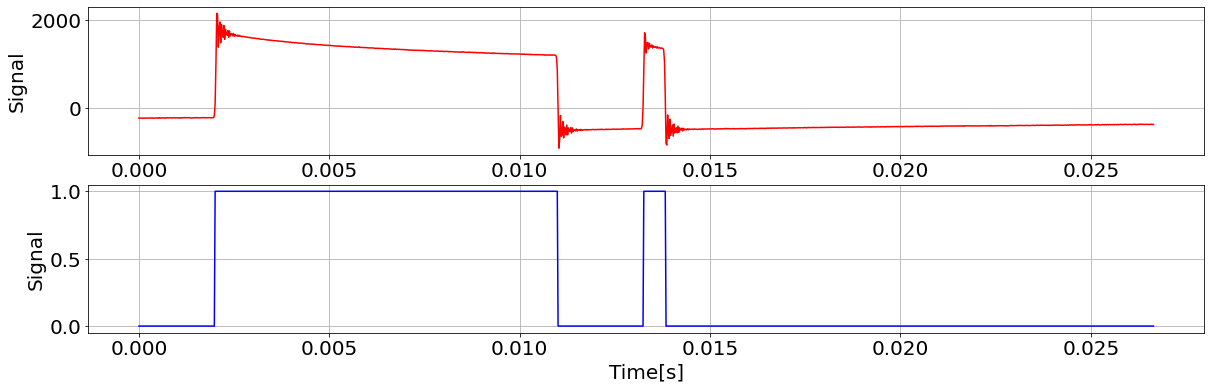

In [15]:
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import numpy as np

# 音声ファイルを読み込む
samplerate, audio = read("audio_remote_vol_1.wav")
binary_signal = [0 if val < 50 else 1 for val in audio]
t = np.linspace(0., len(audio)/samplerate, len(audio))
time_step = 1.0 / samplerate # second

fig = plt.figure(figsize=[20,6])
ax = fig.add_subplot(211)
ax.plot(t, audio, color="#ff0000")
ax2 = fig.add_subplot(212)
ax2.plot(t, binary_signal,
         color="#0000ff")
print(samplerate)

print(time_step)

plt.rcParams["font.size"] = 20
ax.set(xlabel="Time[s]", ylabel='Signal')
ax.grid()
ax2.set(xlabel="Time[s]", ylabel='Signal')
ax2.grid()

## デジタル信号にする

In [16]:
T_length =     {"NEC":16, "AEHA":8, "SONY":4}
T_low_length = {"NEC":8,  "AEHA":4, "SONY":0}
bits = []; state = "wait"
for val in binary_signal:
    if state == "wait":
        if val > 0.5:
            state = "leader_high"; step_count = 0
    elif state == "leader_high":
        if val > 0.5:
            step_count += 1    
        else:
            state = "leader_low"
            leader_in_us = step_count*time_step*1000000
            if leader_in_us > 4000:
                ir_format = "NEC"
            elif leader_in_us > 2800:
                ir_format = "AEHA"
            else:
                ir_format = "SONY"; state = "start_bit"
            T_count = step_count / T_length[ir_format]
    elif state == "leader_low":
        if val > 0.5:
            state = "start_bit"
    elif state == "start_bit":
        if ir_format == "SONY":
            val = - val 
        if val < 0.5:
            state = "data_bit"; step_count = 0
    elif state == "data_bit":
        if val > 0.5:
            bit = 1 if step_count > T_count * 1.7 else 0
            bits.append(bit); state = "start_bit"; step_count=0
        else:
            step_count += 1

print("Format is: " + ir_format)
print("T in step: {}".format(T_count))

bits.append(0)
print(bits)

Format is: NEC
T in step: 26.9375
[0]


## 音声波形を作る(38kHz)

In [17]:
from scipy import signal

ir_fs = 38000 / 2
max_val = np.iinfo(np.int16).max
start_bit =       {"NEC":max_val, "AEHA":max_val, "SONY":0}
data_bit =        {"NEC":0, "AEHA":0, "SONY":max_val}
data_bit_length = {"NEC":3, "AEHA":3, "SONY":2}

data = []; t = 0
for i in range(100):
    data.append([0,0])
for i in range(round(T_count*T_length[ir_format])):
    val = max_val * signal.square(2. * np.pi * ir_fs * t, duty=0.5)
    data.append([val, -val]); t += time_step
for i in range(round(T_count*T_low_length[ir_format])):
    data.append([0, 0])
for i in range(len(bits)):
    for j in range(round(T_count)):
        val = start_bit[ir_format] * signal.square(2. * np.pi * ir_fs * t, duty=0.5)
        data.append([val, -val])
        t += time_step
    n = data_bit_length[ir_format] if bits[i] else 1
    for j in range(round(T_count*n)):
        val = data_bit[ir_format] * signal.square(2. * np.pi * ir_fs * t, duty=0.5)
        data.append([val, -val])
        t += time_step
        
if ir_format != "NEC":
    for j in range(round(T_count)):
        val = max_val * signal.square(2. * np.pi * ir_fs * t, duty=0.5)
        data.append([val, -val]); t += time_step
for i in range(100):
    data.append([0, 0])

# 音声波形を出力する
write('output2.wav', samplerate, np.asarray(data, dtype=np.int16))

Text(0, 0.5, 'Audio Amplitude')

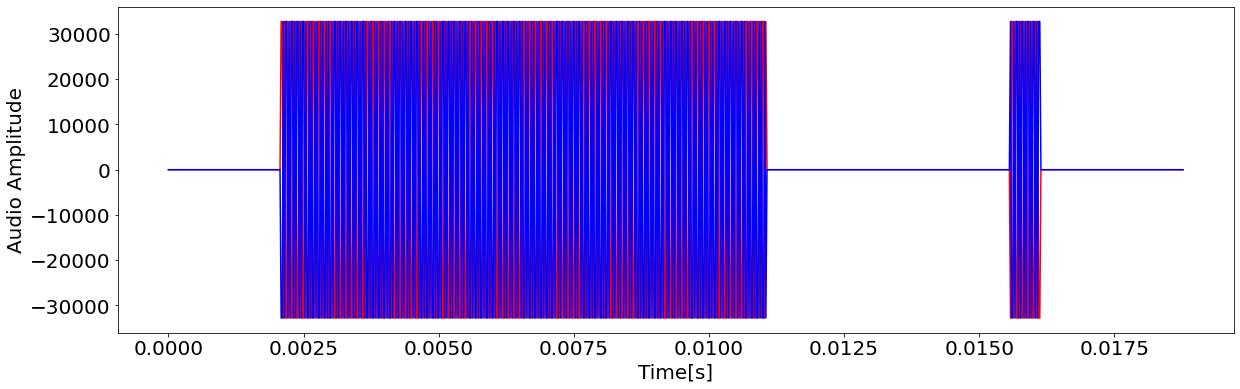

In [18]:
t = np.linspace(0., len(data)/samplerate, len(data))

fig = plt.figure(figsize=[20,6])
plt.plot(t,np.array(data)[:,0], color="#ff0000")
plt.plot(t,np.array(data)[:,1], color="#0000ff")
plt.xlabel("Time[s]")#, fontsize=22)
plt.ylabel("Audio Amplitude")#, fontsize=22)

Text(0, 0.5, 'Audio Amplitude')

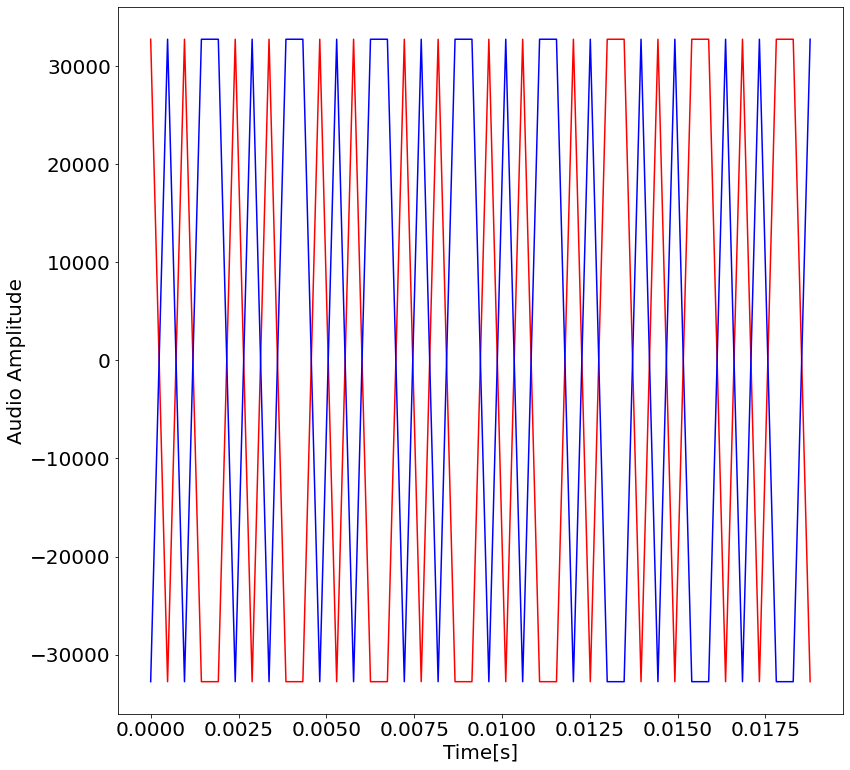

In [19]:
t = np.linspace(0., len(data)/samplerate, 40)

fig = plt.figure(figsize=[13,13])
plt.plot(t,np.array(data)[240:280,0], color="#ff0000")
plt.plot(t,np.array(data)[240:280,1], color="#0000ff")
plt.xlabel("Time[s]")#, fontsize=22)
plt.ylabel("Audio Amplitude")#, fontsize=22)